<a href="https://www.kaggle.com/code/krist0phersmith/build-custom-cnn-for-cancer-detection?scriptVersionId=131487081" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Building CNN From Scratch With Keras For Cancer Detection
***By Kris Smith***

[Link to Project Github](https://github.com/kristopher-smith/CNN-Cancer-Detection/tree/main)

# Problem Description

***For this competition we must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).***

***This is an important problem because metastatic cells are an indicator of stage IV cancer. When cancer has "metasticised" it has left the original tumor/growth and traveled elsewhere throughout the body. This means it is harder to treat and the probability of fatality increases significantly. Identifying metastatic cells on tissue other than the original cancer site therefore helps to confirm this diagnosis allowing more effective and timely treatments/prognosis.***

## Import Libraries

In [1]:
import numpy as np, pandas as pd, tensorflow as tf
import os
import cv2
from PIL import Image 
from glob import glob 
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from tensorflow.keras.models import load_model
from keras.layers.normalization import *
from keras.layers.convolutional import *
from keras.layers.core import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline


print(os.listdir("../input/histopathologic-cancer-detection"))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################################

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['sample_submission.csv', 'train_labels.csv', 'test', 'train']
Num GPUs Available:  1


---

# Data

## Data Description

***In the authors words:***

_"[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability."_

***Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.***

## EDA

### Load Data

In [2]:
print(f'Total Number of Samples in Training Data = {len(os.listdir("../input/histopathologic-cancer-detection/train"))}')
print(f'Total Number of Samples in Test Data = {len(os.listdir("../input/histopathologic-cancer-detection/test"))}')

Total Number of Samples in Training Data = 220025
Total Number of Samples in Test Data = 57458


***Since the labels and images are provided to us as seperate files we need to read them both into a dataframe for processing and training easily.***

***The below cell reads in the image and label data and concatenates the filepath including each images unique id with its image filetype and label.***

In [3]:
path = "../input/histopathologic-cancer-detection/"
train_path = path + 'train/'
test_path = path + 'test/'

### Read data into pandas frames ###
## Load training and testing file names into frames
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) 

## Isolate the id from file names and store as id features in seperate column
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) 

## Read in training labels
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## Add Labels to training data 
df = df.merge(labels, on = "id") # merge labels and filepaths
df.sample(7)

,path,id,label
34130,../input/histopathologic-cancer-detection/trai...,6d5e7d752b1f2debfe3193c6d200942bde60826c,0
179142,../input/histopathologic-cancer-detection/trai...,a7cb4fcd0f6751cbf4febb352fef9fcd609514cc,0
66847,../input/histopathologic-cancer-detection/trai...,6300ffcd2865cc5a890fd1534fc1642dafbce29a,1
51883,../input/histopathologic-cancer-detection/trai...,f11b25beba4afe7dc46f2f861fafee04c1f8f844,1
79397,../input/histopathologic-cancer-detection/trai...,e82ce5b1f55f9c1da13ea1072430cb6144cbc803,0
24807,../input/histopathologic-cancer-detection/trai...,5512442c715d7108d90cef9c4d5f3286d646d853,1
83982,../input/histopathologic-cancer-detection/trai...,6560a97905304ec12d8105ced1fbddd4e2642b3c,0


## Class Distributions

<AxesSubplot: title={'center': 'Class Distribution in Training Data'}>

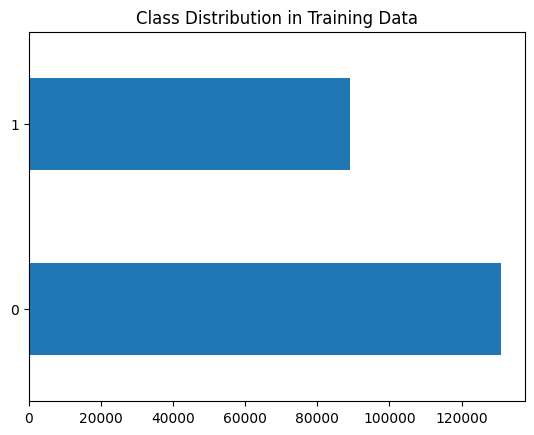

In [4]:
labels['label'].value_counts().plot(kind='barh', title='Class Distribution in Training Data')

In [14]:
n = len(labels)
num_pos = labels['label'].sum()
num_neg = n - num_pos
prop_pos = round(num_pos/n, 2)
prop_neg = round(num_neg/n, 2)

print(f'Total Number of Positive Samples in Training Data = {num_pos} ')
print(f'Total Number of Negative Samples in Training Data = {num_neg} ')
print(f'Proportion of Positive Samples in Training Data = {prop_pos}%')
print(f'Proportion of Negative Samples in Training Data = {prop_neg}%')

Total Number of Positive Samples in Training Data = 89117 
Total Number of Negative Samples in Training Data = 130908 
Proportion of Positive Samples in Training Data = 0.41%
Proportion of Negative Samples in Training Data = 0.59%


***Looks like there is a class imbalance but we seem to have a decent amount for each class so I decided to go ahead and see how the model works with this imbalanced data.***

## Inspect Some Samples From Both Positive and Negative Classes

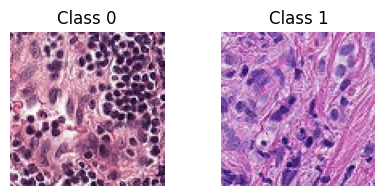

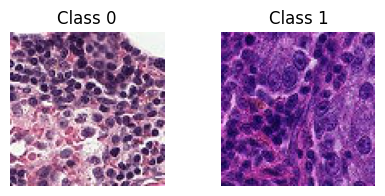

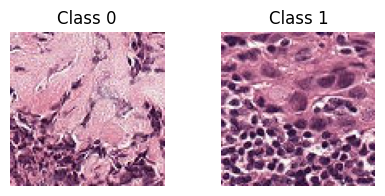

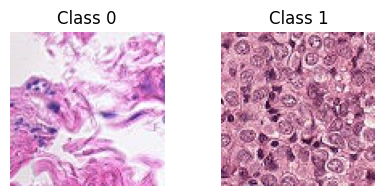

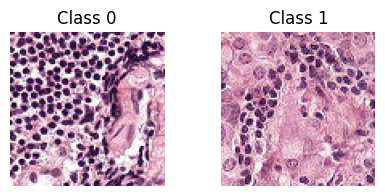

In [5]:
## Filter dataframe to get a subset of each class
class0 = df[df['label'] == 0]
class1 = df[df['label'] == 1]

for image in range(5):
    ## Select a random sample from each class
    sample0 = class0.sample(1)
    sample1 = class1.sample(1)

    ## Open image files and plot
    img_path0 = sample0['path'].values[0]
    img_path1 = sample1['path'].values[0]

    img0 = Image.open(img_path0)
    img1 = Image.open(img_path1)

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))

    ax[0].imshow(img0)
    ax[0].set_title('Class 0')
    ax[0].axis('off')

    ax[1].imshow(img1)
    ax[1].set_title('Class 1')
    ax[1].axis('off')

    plt.show()

***According to the five minutes of extensive research I did on the interwebs, apparently metastatic cells should appear a different size, shape, or pattern compared to the healthy cells around them.***

***Inspecting these images I am realizing that I am not a medical professional and therefore I can see no consistent differences between the positive and negative class images. Therefore I will be relying on the labels and the model to distinguish between the two.***

---
# Feature Engineering

## Pre-Processing

***I have chosen to split the training data into 90/10% training/validation sets respectively.***

***For creating more out of the training data I have augmented the images with horizontal and vertical flips, as well as rotating within a certain range. This will give the model more to train on and since the images are direction ignorant, manipulating them in this manner preserves the data.***

In [15]:
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
# df = df.sample(12800*4) ## Smaller set for quick experimentation

## ImageDataGenerator method requires string data type labels
df['label'] = df['label'].astype(str)

def append_ext(ID):
    return(ID+".tif")


df["id"] = df["id"].apply(append_ext)



train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,                               
        rotation_range=15,
        rescale=1./255, ## Converts RGB values from [0, 255] ===> [0, 1]
        validation_split=0.10
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '../input/histopathologic-cancer-detection/train'
valid_path = '../input/histopathologic-cancer-detection/train'

train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
                subset='training',
                target_size=(96, 96),
                batch_size=64,
                class_mode='binary'
                )

validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
                subset='validation', 
                target_size=(96, 96),
                batch_size=64,
                shuffle=False,
                class_mode='binary'
                )

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.


## Building Model Architectures

***Classic CNN architectural design choices include:***
*  ***Convolutions use filters to transform or extract features from the image/pixels by sliding through the image and applying some matrix operations at each level. Since convolutions are an abstracting concept most of the design choices are surrounding the filters(kernels) themselves.***

* ***Filter(kernel) size over the years has mainly converged to a 3x3 by the community however in some cases other sizes have been used in parallel with this window size.***

* ***Initial layer feature extractions are more broad and deeper layers become increasingly granular. This is so the model can learn different degrees of patterns in the image. This is done by using the filter size and number of filters. Since after experimenting I have settled on using solely a 3x3 size filter, you will notice this being done by number of filters at each layer i.e. the `filters` parameter increasing throughout.***

* ***Padding is used so as to preserve as much information as possible with each kernel. Without padding a 3x3 filter(kernel) would mean the outer edge of pixels would be lost. A 5x5 filter(kernel) would lose the outside 2 pixels around the entire image and so on.***

* ***Striding may be used to reduce complexity and simplify the features the model uses. Striding is exactly what it sounds like, when the filter(kernel) traverses across and down the image it can do so one pixel at a time`(stride=1)`, or in larger strides skipping some pixels and abstracting away pixels in between along the way. This will significantly decrease the size/number of features/weights and make the model simpler and computation much less intensive for training/inference. The trade off would be abstracting away important features/weights and losing accuracy overall.***

* ***Pooling can be used similar to striding wherein a specified number of pixels is abstracted into the max value in it's pool. This value pertains to the RGB value so that for example in the case of Max Pooling, all pixels in each particular section(pool size) of the image will be transformed to the same value in this case the max(in most cases darkest or strongest value if inverted) value for that region. The pool slides across and down the image applying this transformation just like the convolution filter/kernel.***

* ***Dropout can be used to keep a random set of weights hidden(set to zero) so that the model must optimize using less weights and therefore will typically generalize better at inference time. We can apply dropout after any set of layers but it is typically done directly before or after a subsampling/abstracting layer such as a pooling layer. We can choose the percentage of weights to keep hidden.***

* ***Regularization is when we transform the data to keep the values in the same range and typically limit the range to [0, 1] for example. When Dropout is being used regularization may not be unnecessary.***


### Model 1

In [ ]:
with tf.device('/gpu:0'):  
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (96, 96, 3)))
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.3)) ## Hide some weights until inference to generalize better
    model.add(MaxPooling2D(pool_size=3)) ## Subsample layer


    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.3)) ## Hide some weights until inference to generalize better
    model.add(MaxPooling2D(pool_size=3)) ## Subsample layer


    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.3)) ## Hide some weights until inference to generalize better
    model.add(MaxPooling2D(pool_size=3)) ## Subsample layer


    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
    model.add(Dropout(0.3)) ## Hide some weights until inference to generalize better
    
    ## This is the actual 'classifying' layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3)) ## Hide some weights until inference to generalize better
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    ## Compile model and initialize hyperparameters for learning rate and evaluation metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 dropout (Dropout)           (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        4640      
                                                        

2023-05-29 17:26:28.103486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3094/3094 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.5939 - auc: 0.5028

### Model 2

In [ ]:
# with tf.device('/gpu:0'):  
#     model = Sequential()
    
#     model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (96, 96, 3)))
#     model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
#     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
#     model.add(Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu')) ## Try for more accurate results
# #     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
# #     model.add(MaxPooling2D(pool_size=3)) ## Subsample layer


#     model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
#     model.add(Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu')) ## Try for more accurate results
# #     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
# #     model.add(MaxPooling2D(pool_size=3)) ## Subsample layer


#     model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
#     model.add(Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same', activation='relu')) ## Try for more accurate results
# #     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
# #     model.add(MaxPooling2D(pool_size=3)) ## Subsample layer


#     model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
#     model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
#     model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
#     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
    
#     ## This is the actual 'classifying' layer
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.3)) ## Regularization: hide some weights until inference to generalize better
#     model.add(Dense(1, activation='sigmoid'))
#     model.summary()
#     ## Compile model and initialize hyperparameters for learning rate and evaluation metrics
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

#     STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
#     STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

#     history = model.fit(train_generator,
#                         steps_per_epoch=STEP_SIZE_TRAIN,
#                         epochs=10,
#                         validation_data=validation_generator,
#                         validation_steps=STEP_SIZE_VALID)


In [ ]:
model.evaluate_generator(generator=validation_generator)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model.save('Keras_CNN_3.h5')  

# Inference

In [ ]:
with tf.device('/GPU:0'):
#     model = load_model('/kaggle/input/cancer-detections-cnn2/Keras_CNN_1.h5')
    model = load_model('/kaggle/working/Keras_CNN_3.h5')

test_df = pd.read_csv(path + 'sample_submission.csv')

TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join(test_path,'*.tif'))
submission = pd.DataFrame()
print(len(testing_files))

for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    
    # Stack images into a batch
    images = np.stack(data_frame.image, axis=0) / 255.0
    # Predict on the entire batch
    predictions = model.predict(images).flatten()
    
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])

# Submission

In [ ]:
submission.to_csv('submission.csv', index=False, header=True)
print(len(submission))
submission.head()